In [1]:
!pip install chart_studio

In [2]:
!pip install plotly

In [3]:
!pip install cufflinks

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)

from wordcloud import WordCloud



In [5]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Case.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Region.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/PatientInfo.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Policy.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/SearchTrend.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/SeoulFloating.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Time.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/TimeGender.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Weather.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/TimeAge.csv
/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/TimeProvince.csv


Load and check data

1. TimeAge - time series data on the patients by age
2. TimeProvince - time series data by administrative region
3. Region - metadata on each region
4. TimeGender - time series data on the patients by sex
5. Time - time series data on the tests and the results
6. Case - data on infection cases (path of transmission)
7. Weather - time series data on the weather in each region
8. PatientInfo - sparse data on the profiles of some confirmed patients
9. SeoulFloating - time series data on the floating population in Seoul
10. SearchTrend - time series data on the search keywords related to COVID-19 and other respiratory diseases
11. Policy - sparse data on the policies implemented by S.Korean government on COVID-19
-. PatientRoute - saprse data on the patients' activities before being confirmed
    # Discarded from the original dataset as of 2020-06-30


In [6]:
timeage = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/TimeAge.csv")
region = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Region.csv")
time = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Time.csv")
weather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Weather.csv")
searchtrend = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/SearchTrend.csv")
timeprovince = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/TimeProvince.csv")
timegender = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/TimeGender.csv")
patientinfo = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/PatientInfo.csv")

#patientroute = pd.read_csv("/kaggle/input/coronavirusdataset/PatientRoute.csv")
case = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/covid/input/coronavirusdataset/Case.csv")

## Deceased People and Age Distribution
- timeage data를 이용하여 연령별 deceased(사망자) 분석

In [7]:
timeage.head()

,date,time,age,confirmed,deceased
0,2020-03-02,0,0s,32,0
1,2020-03-02,0,10s,169,0
2,2020-03-02,0,20s,1235,0
3,2020-03-02,0,30s,506,1
4,2020-03-02,0,40s,633,1


In [8]:
timeage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089 entries, 0 to 1088
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       1089 non-null   object
 1   time       1089 non-null   int64 
 2   age        1089 non-null   object
 3   confirmed  1089 non-null   int64 
 4   deceased   1089 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 42.7+ KB


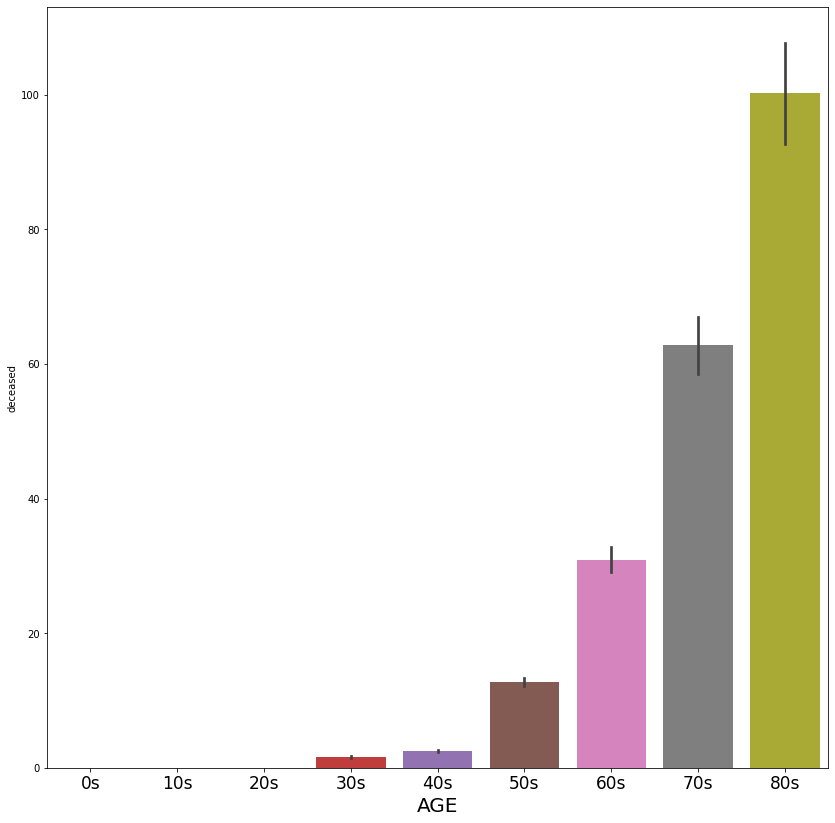

In [9]:
f,ax = plt.subplots(figsize = (14,14))
ax = sns.barplot(x="age",y="deceased",data=timeage)
plt.xlabel("AGE",fontsize = 20)
plt.xticks(fontsize = 17)
plt.show()

- 50s 부터 사망자수가 늘고 있음을 볼 수 있다.
- 40s 부터 증가폭이 커지고 있다.

In [10]:
#The age's in the timeage dataframe has 's' in the and, so we have to remove them to make them float
timeage.age = [i.rsplit('s',1)[0] if 's' in i else i for i in timeage.age]
timeage.age.value_counts()

0     121
10    121
20    121
30    121
40    121
50    121
60    121
70    121
80    121
Name: age, dtype: int64

In [13]:
timeage.age = timeage.age.astype(float)


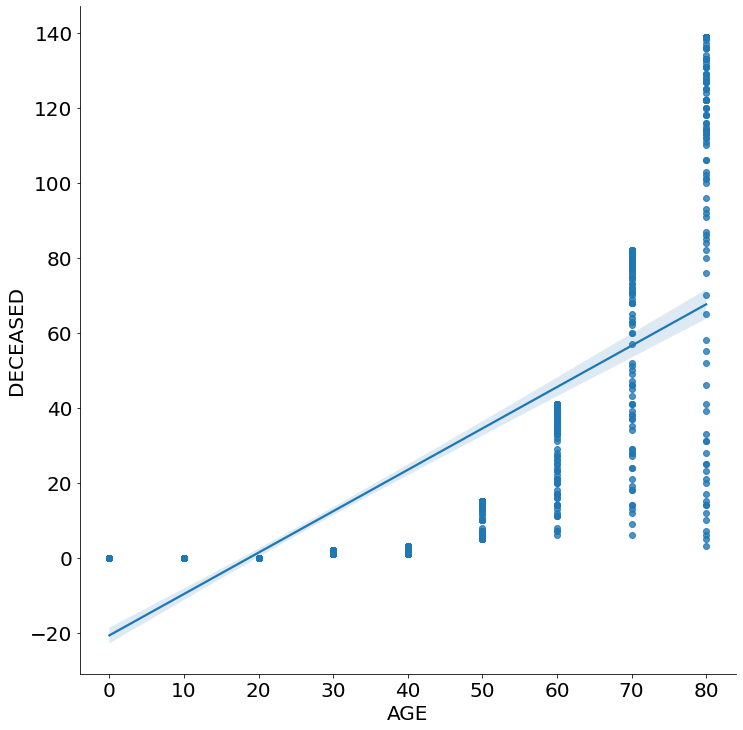

In [15]:
sns.lmplot(x="age",y='deceased',data=timeage,height = 10)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("AGE",fontsize = 20)
plt.ylabel("DECEASED",fontsize = 20)
plt.show()

## People's Status by Their Age and Gender
- patientinfo data를 이용한 나이와 성별에 따른 상태 분석

In [16]:
patientinfo.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [17]:
#Finding null rows with respect to age column
patientinfo[patientinfo.age.isnull()]

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
563,1000000564,NaN,NaN,Korea,Seoul,Jungnang-gu,etc,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
564,1000000565,NaN,NaN,Korea,Seoul,Seongdong-gu,overseas inflow,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
565,1000000566,NaN,NaN,Korea,Seoul,Gwanak-gu,overseas inflow,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
566,1000000567,NaN,NaN,Korea,Seoul,Gangnam-gu,overseas inflow,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
567,1000000568,NaN,NaN,Korea,Seoul,Nowon-gu,overseas inflow,NaN,NaN,NaN,2020-04-06,NaN,NaN,released
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,6100000130,NaN,NaN,Korea,Gyeongsangnam-do,Hapcheon-gun,overseas inflow,NaN,NaN,NaN,2020-06-15,NaN,NaN,released
5161,7000000016,NaN,NaN,Korea,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-16,2020-06-24,NaN,released
5162,7000000017,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,72,NaN,2020-06-18,NaN,NaN,isolated
5163,7000000018,NaN,NaN,Bangladesh,Jeju-do,Jeju-do,overseas inflow,NaN,NaN,NaN,2020-06-18,NaN,NaN,isolated


In [18]:
#Dropping the null values in the age column
patientinfo.dropna(subset=['age'],inplace=True)
patientinfo.age.isnull().any() # False = There are no null entries in the age column

False

In [19]:
#The age's in the patientinfo dataframe has 's' in the end, so we have to remove them to make them integer
patientinfo.age = [i.rsplit('s',1)[0] if 's' in i else i for i in patientinfo.age]

In [20]:
patientinfo.age.value_counts()

20     899
50     667
30     523
40     518
60     482
70     232
10     178
80     170
0       66
90      49
100      1
Name: age, dtype: int64

Text(0, 0.5, 'AGE')

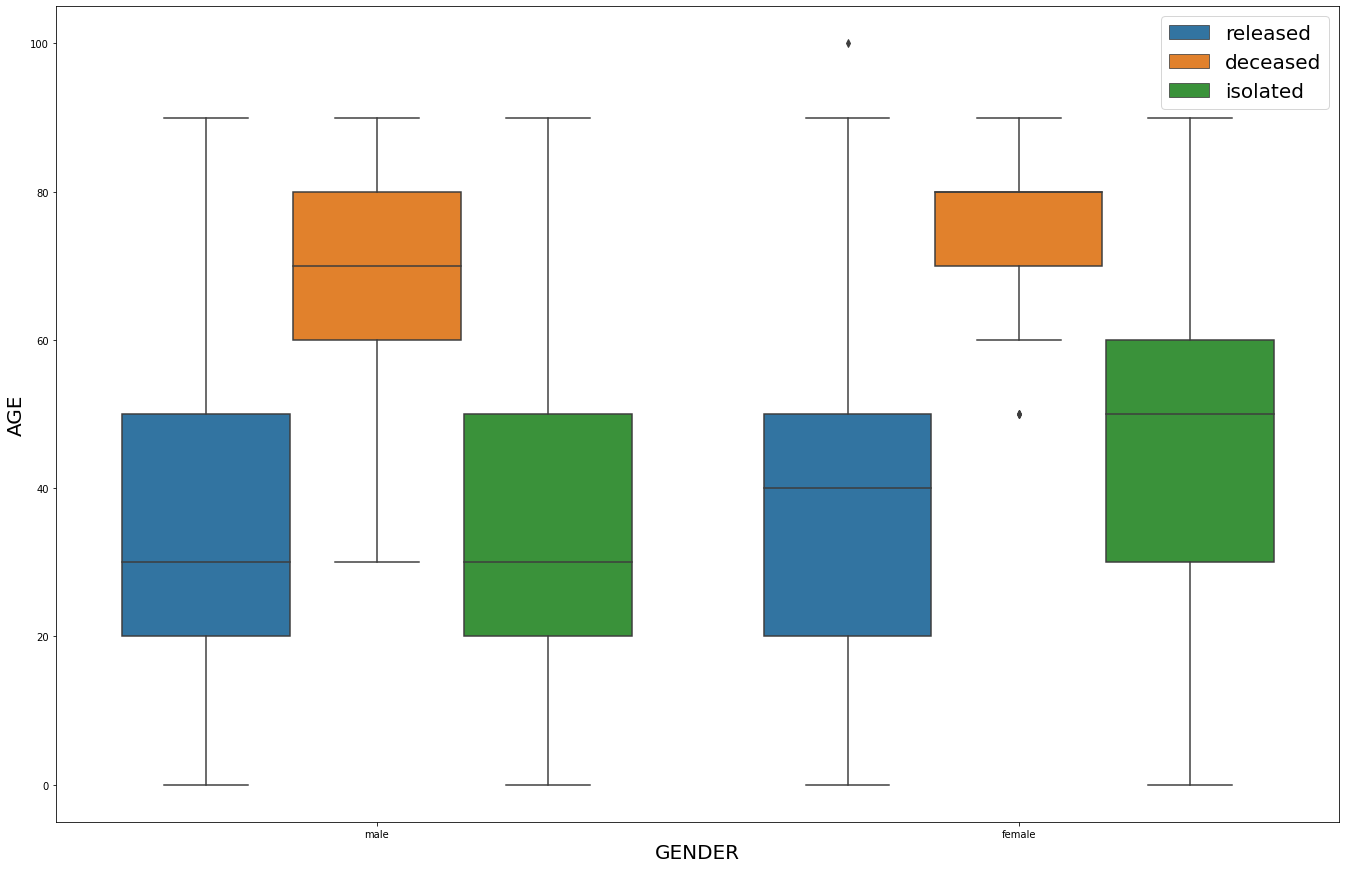

In [21]:
patientinfo.age = patientinfo.age.astype(int) #making entries integer
f,ax = plt.subplots(figsize = (23,15))
ax = sns.boxplot(x='sex',y="age",hue="state",data=patientinfo)
plt.legend(prop={'size' : 20})
plt.xlabel("GENDER",fontsize = 20)
plt.ylabel("AGE",fontsize = 20)

+ 성별에 따른 차이점을 도출 하기는 어렵지만 사망자(deceased)의 범위는 남자가 넓어 추가 분석이 필요해 보입니다.


## region & case 분석
- region 데이터의 academy_ratio 가 높은 경우 인구 밀집도가 높을 것이다.(대도시에 교육이 많기 때문이라고 생각함)
- 인구 밀집도가 높은 곳에서 코로나 확진자가 높을 것이라고 생각합니다.
- case 데이터의 경우와 비교하여 대확진이 발생한 곳은 대도시라고 예상한 결과를 확인해본다.

In [22]:
region


,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739
1,10010,Seoul,Gangnam-gu,37.518421,127.047222,33,38,0,4.18,13.17,4.3,3088
2,10020,Seoul,Gangdong-gu,37.530492,127.123837,27,32,0,1.54,14.55,5.4,1023
3,10030,Seoul,Gangbuk-gu,37.639938,127.025508,14,21,0,0.67,19.49,8.5,628
4,10040,Seoul,Gangseo-gu,37.551166,126.849506,36,56,1,1.17,14.39,5.7,1080
...,...,...,...,...,...,...,...,...,...,...,...,...
239,61160,Gyeongsangnam-do,Haman-gun,35.272481,128.406540,16,20,0,1.19,23.74,14.7,94
240,61170,Gyeongsangnam-do,Hamyang-gun,35.520541,127.725177,13,12,0,1.01,32.65,20.9,83
241,61180,Gyeongsangnam-do,Hapcheon-gun,35.566702,128.165870,17,15,0,0.71,38.44,24.7,96
242,70000,Jeju-do,Jeju-do,33.488936,126.500423,113,123,4,1.53,15.10,6.4,1245


In [23]:
region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   code                      244 non-null    int64  
 1   province                  244 non-null    object 
 2   city                      244 non-null    object 
 3   latitude                  244 non-null    float64
 4   longitude                 244 non-null    float64
 5   elementary_school_count   244 non-null    int64  
 6   kindergarten_count        244 non-null    int64  
 7   university_count          244 non-null    int64  
 8   academy_ratio             244 non-null    float64
 9   elderly_population_ratio  244 non-null    float64
 10  elderly_alone_ratio       244 non-null    float64
 11  nursing_home_count        244 non-null    int64  
dtypes: float64(5), int64(5), object(2)
memory usage: 23.0+ KB


In [24]:
case

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Yongsan-gu,True,Itaewon Clubs,139,37.538621,126.992652
1,1000002,Seoul,Gwanak-gu,True,Richway,119,37.48208,126.901384
2,1000003,Seoul,Guro-gu,True,Guro-gu Call Center,95,37.508163,126.884387
3,1000004,Seoul,Yangcheon-gu,True,Yangcheon Table Tennis Club,43,37.546061,126.874209
4,1000005,Seoul,Dobong-gu,True,Day Care Center,43,37.679422,127.044374
...,...,...,...,...,...,...,...,...
169,6100012,Gyeongsangnam-do,-,False,etc,20,-,-
170,7000001,Jeju-do,-,False,overseas inflow,14,-,-
171,7000002,Jeju-do,-,False,contact with patient,0,-,-
172,7000003,Jeju-do,-,False,etc,4,-,-


In [25]:
case.confirmed

0      139
1      119
2       95
3       43
4       43
      ... 
169     20
170     14
171      0
172      4
173      1
Name: confirmed, Length: 174, dtype: int64

In [26]:
fig = go.Figure(data=go.Scattergeo(
    lon =region.longitude,
    lat = region.latitude,
    text = region.city,
    mode = 'markers',
    marker= dict(
        size=region.academy_ratio*10,
        line = dict(width=1,color = "white"),
        opacity=.8,
        color = 'red'
    )
))

fig.update_layout(title="academy ratio Locations",hovermode='closest')               

fig.show(renderer="colab")

+ 대도시와 수도권지역이 학업인구 비중이 높습니다.


In [27]:
fig = go.Figure(data=go.Scattergeo(
    lon =case.longitude,
    lat = case.latitude,
    text = case.city,
    mode = 'markers',
    marker= dict(
        size=8,
        line = dict(width=1,color = "white"),
        opacity=.8,
        color = 'blue'
    )
))

fig.update_layout(title="Patients Locations",hovermode='closest')               

fig.show(renderer="colab")

- 대규모 감염의 경우를 나타낸 지도입니다.

In [28]:
fig = go.Figure(data=go.Scattergeo(
    lon =case.longitude,
    lat = case.latitude,
    text = case.confirmed,
    mode = 'markers',
    marker= dict(
        size=case.confirmed*0.1,
        line = dict(width=1,color = "white"),
        opacity=.5,
        color = 'blue'
    )
))

fig.update_layout(title="Patients Locations",hovermode='closest')               

fig.show(renderer="colab")

+ 2020년 초 대구경북 지역의 신천지 확진자수가 다른 값 보다 너무 커서 원의 크기가 큽니다.

In [29]:
fig = go.Figure(data=go.Scattergeo(
    lon =region.longitude,
    lat = region.latitude,
    text = region.city,
    mode = 'markers',
    name = "City location",
    marker= dict(
        size=region.academy_ratio*10,
        line = dict(width=1,color = "white"),
        opacity=.8,
        color = 'red'
    )
))

fig.add_trace(go.Scattergeo(
    lon =case.longitude,
    lat = case.latitude,
    text = case.city,
    mode = 'markers',
    name = "Patients",
    marker= dict(
        size=8,
        line = dict(width=1,color = "white"),
        opacity=.8,
        color = 'blue'
    )
))


fig.update_layout(title="combined",hovermode='closest')               

fig.show(renderer="colab")

+ 대도시와 수도권에서의 인구 밀집도가 높기 때문에 대규모 전파의 경우 위치가 동일 함을 확인 할 수 있습니다.
+ 사회적 거리두기를 통해 접촉을 막는 정책이 필요하다고 판단 할 수 있습니다.